In [1]:
import torch
import polars as pl
from sklearn.preprocessing import StandardScaler, RobustScaler
import numpy as np
from torch.utils.data import Dataset,DataLoader
import torch.nn as nn
import matplotlib.pyplot as plt
import pickle
from tqdm import tqdm
import gc
import accelerate

/Users/jingyu/miniforge3/envs/dlbase/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# 1. use a basic attention architecture as demo  
**Here I utilize the simplest architecture to demonstrate the model's workflow. Even with this minimal architectural design, the model still achieves a good performance.**   
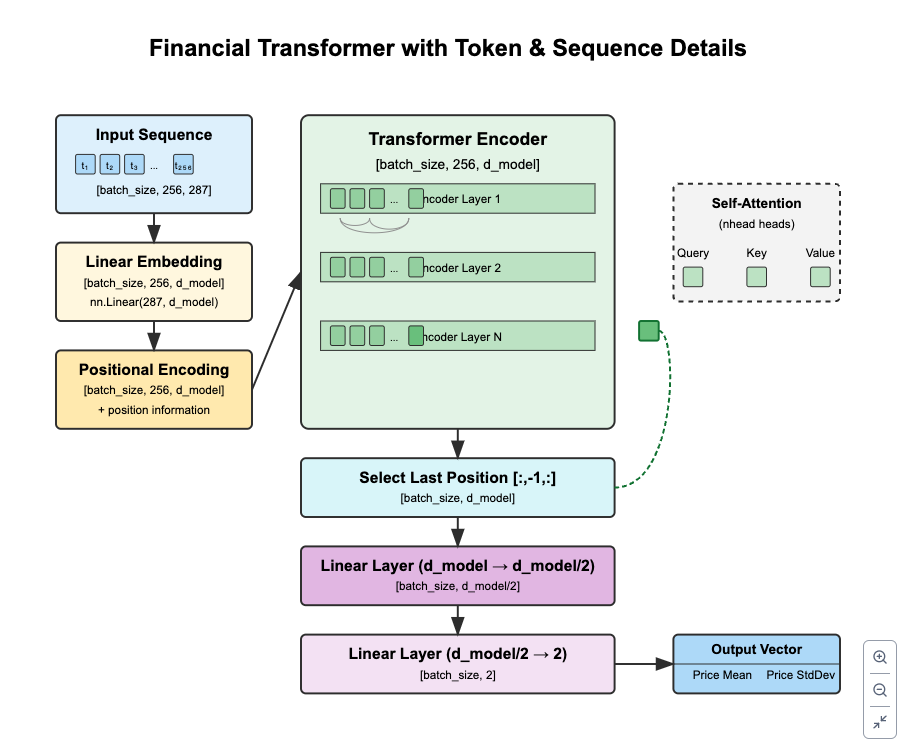

Here I use the last positon of encoder output as the input of final distributional head. This is also the simplest way. The model performance would be inproved with other tricks. 

In [3]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)
        
    def forward(self, x):
        return x + self.pe[:, :x.size(1)]

In [4]:
class T_Transformer(nn.Module):
    def __init__(self, input_dim, d_model, nhead, num_layers,dropout):
        super().__init__()
        self.embedding = nn.Linear(input_dim, d_model)
        self.pos_encoder = PositionalEncoding(d_model)
        
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead,batch_first=True,dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        
        self.output_layer1 = nn.Linear(d_model, d_model//2)
        self.output_layer = nn.Linear(d_model//2, 2)
        
    def forward(self,src):
        src = self.embedding(src)
        src = self.pos_encoder(src)
        encoder_output = self.transformer_encoder(src)
        
        output1 = self.output_layer1(encoder_output[:,-1,:])
        output = self.output_layer(output1)
        
        return output

# 2. prepare dataset in training,validation,and test

In [8]:
def load_scaler_pickle(filename):
    """Load the scaler from a file using pickle."""
    try:
        with open(filename, 'rb') as f:
            return pickle.load(f)
    except Exception as e:
        print(f"Error loading scaler: {e}")
        return None

In [2]:
class test_dataset(Dataset):
    def __init__(self,data,T=5):
        self.data = torch.FloatTensor(np.array(data))
        self.T = T
    def __len__(self):
        return len(self.data)-self.T
    def __getitem__(self,idx):
        return self.data[idx:idx+self.T+1,:-2], self.data[idx+self.T][-2:]

In [9]:
data = pl.read_parquet('standardized_data.parquet')
scaler = load_scaler_pickle('scaler_dict.pkl')

In [10]:
sequence_length = 256
batch_size = 128

size = len(data)

training_size = int(0.7*size)
vali_size = int(0.1*size)
test_size = int(0.2*size)

training_set = test_dataset(data[0:training_size],sequence_length)
vali_set = test_dataset(data[training_size-sequence_length:training_size+vali_size],sequence_length)
test_set = test_dataset(data[training_size+vali_size-sequence_length:],sequence_length)

len(training_set),len(vali_set),len(test_set)

(27104, 3908, 7819)

In [11]:
t_loader = DataLoader(training_set, batch_size=batch_size,shuffle=True)
v_loader = DataLoader(vali_set, batch_size=batch_size)
test_loader = DataLoader(test_set, batch_size=batch_size)

# 3.create model

In [12]:
# sequence_length = 256
# batch_size = 128
d_imput = 287
d_model = 64
nhead = 8
num_layers = 6
learn_rate = 1e-4
dropout = 0.1

In [13]:
t_model = T_Transformer(d_imput,d_model,nhead,num_layers,dropout)

In [14]:
device = torch.device('mps' if torch.mps.is_available() else 'cpu')
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(t_model.parameters(), lr=learn_rate)
t_model = t_model.to(device)
num_epochs = 1000

# 4. training the model

In [19]:
def training(model,device,criterion,optimizer,num_epochs,t_loader,v_loader):

    train_losses = []
    val_losses = []
    best_val_loss = float('inf')

    # model, optimizer, t_loader = accelerator.prepare(model, optimizer, t_loader)
    
    for epoch in range(num_epochs):
        # Training
        model.train()
        train_loss = 0
        
        loop = tqdm(enumerate(t_loader), total=len(t_loader))

        # for x_batch, y_batch in t_loader:
        for step,(x_batch, y_batch) in loop:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)

            optimizer.zero_grad()
            y_pred = model(x_batch)
            loss = criterion(y_pred, y_batch)

            loss.backward()
            # accelerator.backward(loss)
            optimizer.step()

            train_loss += loss.item() 
            
            loop.set_description(f'Epoch [{epoch+1}/{num_epochs}]')
            loop.set_postfix(loss=train_loss/(step+1))

        del(loop)
        del(x_batch)
        del(y_batch)
        del(y_pred)

        train_loss /= len(t_loader)

        # Validation
        model.eval()
        val_loss = 0

        # create new temp dataset
        _V_loader = v_loader
        with torch.no_grad():
            for x_batch, y_batch in _V_loader:
                x_batch, y_batch = x_batch.to(device), y_batch.to(device)
                y_pred = model(x_batch)
                val_loss += criterion(y_pred, y_batch).item()

        del(_V_loader)
        del(x_batch)
        del(y_batch)
        del(y_pred)

        val_loss /= len(v_loader)

        train_losses.append(train_loss)
        val_losses.append(val_loss)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'full_model_best_model.pth')

        # if epoch % 10 == 0:
        if True:
            print(f'Epoch {epoch}: Train Loss = {train_loss:.4f}, Val Loss = {val_loss:.4f}')

        gc.collect()   
        torch.mps.empty_cache()
    
    return train_losses,val_losses

In [ ]:
train_loss,val_loss = training(
    model = t_model,
    device = device,
    criterion = criterion,
    optimizer = optimizer,
    num_epochs =num_epochs,
    t_loader = t_loader,
    v_loader = v_loader
)

Epoch [1/1000]:  14%|█▉            | 29/212 [00:45<04:42,  1.54s/it, loss=0.496]

In [79]:
test_loss,predictions,actuals = test_model(
    model = t_model,
    device = device,
    criterion = criterion,
    test_loader = test_loader 
)

In [80]:
predictions_mean = dfprocessor.scaler_dict['traget_mean'].inverse_transform(np.expand_dims(predictions[:,0],axis=0))[0]
predictions_std = dfprocessor.scaler_dict['traget_std'].inverse_transform(np.expand_dims(predictions[:,1],axis=0))[0]
actuals_mean = dfprocessor.scaler_dict['traget_mean'].inverse_transform(np.expand_dims(actuals[:,0],axis=0))[0]
actuals_std = dfprocessor.scaler_dict['traget_std'].inverse_transform(np.expand_dims(actuals[:,1],axis=0))[0]

# 5. model performance in test dataset

In [6]:
def test_model(model,device,criterion,test_loader):
    model.eval()
    test_loss = 0
    predictions = []
    actuals = []
    with torch.no_grad():
        for x_batch, y_batch in test_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            y_pred = model(x_batch)
            test_loss += criterion(y_pred, y_batch).item()

            # print(np.shape(y_pred.cpu().numpy()))

            predictions.extend(y_pred.cpu().numpy())
            actuals.extend(y_batch.cpu().numpy())

    test_loss /= len(test_loader)
    return test_loss,np.array(predictions),np.array(actuals)

In [7]:
def picture(train_losses,val_losses,predictions_mean,actuals_mean,predictions_std,actuals_std):
    plt.figure(figsize=(15, 10))

    plt.subplot(2, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training Progress')

    plt.subplot(2, 2, 2)
    plt.plot(actuals_mean, label='Actual_mean')
    plt.plot(predictions_mean, label='Predicted_mean')
    plt.xlabel('Time Step')
    plt.ylabel('Value')
    plt.legend()
    plt.title('Prediction mean vs Actual mean')   

    plt.subplot(2, 2, 3)
    plt.plot(actuals_std, label='Actual std ')
    plt.plot(predictions_std, label='Predicted std')
    plt.xlabel('Time Step')
    plt.ylabel('Value')
    plt.legend()
    plt.title('Prediction std  vs Actual std')   

    plt.tight_layout()
    plt.show()

**1000 epoches takes too long in this environment. The following diagrams are model after 100 epoches, which is Undertrained**

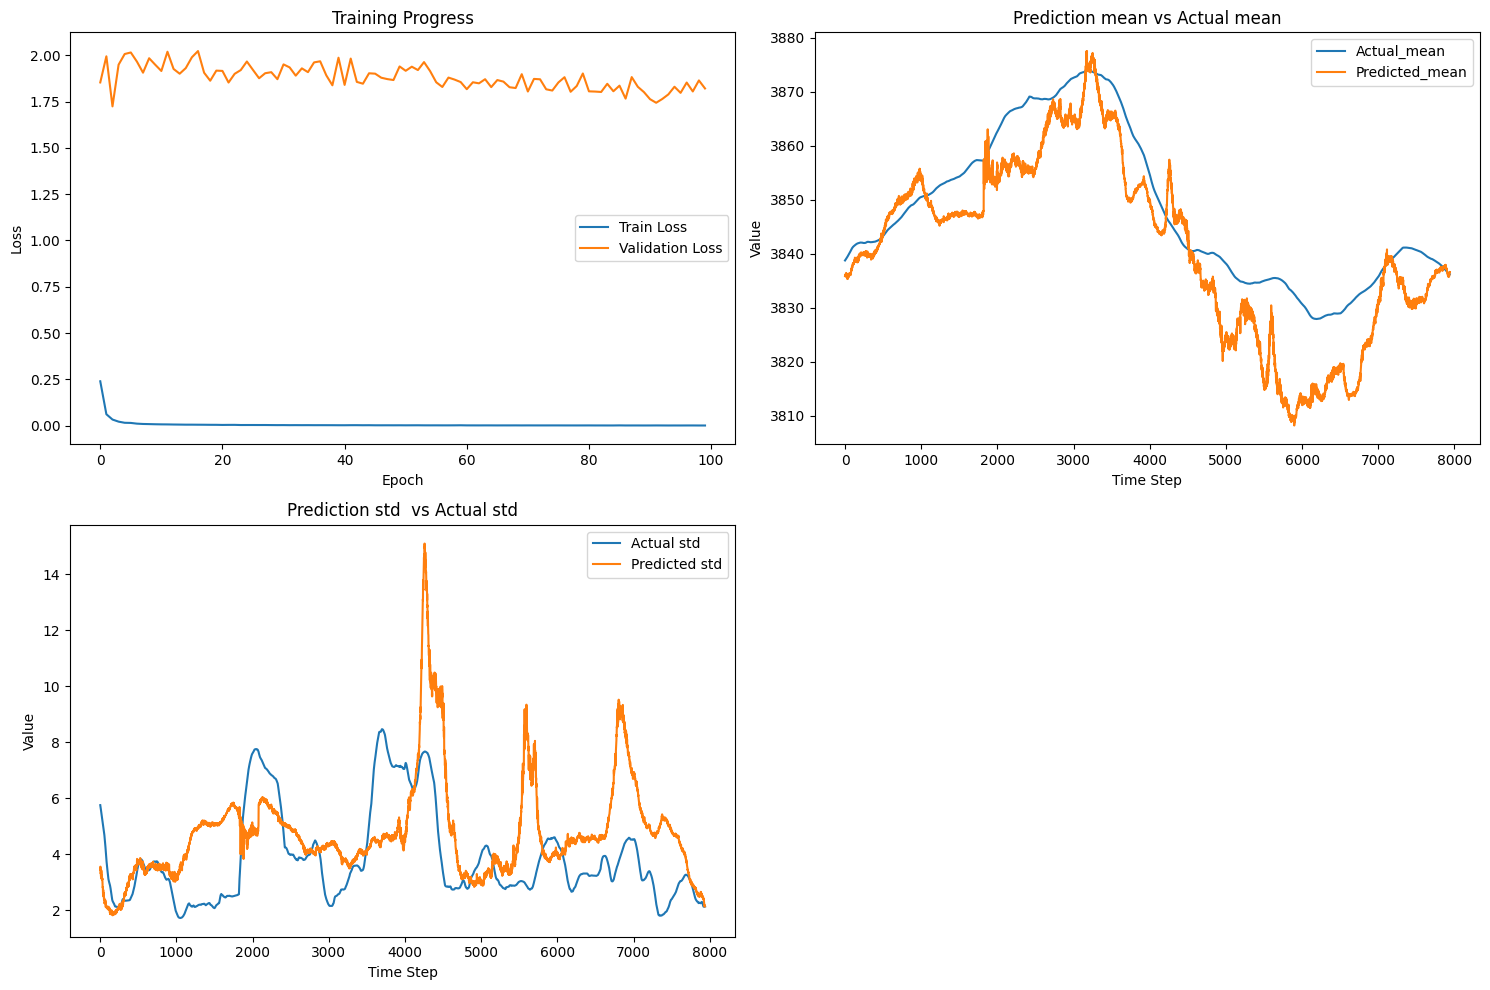

In [81]:
picture(train_loss,val_loss,predictions_mean,actuals_mean,predictions_std,actuals_std)

In [82]:
torch.save(t_model.state_dict(), 'best_model0106.pth')

**Here is the model performance in test dataset after enough training.**  
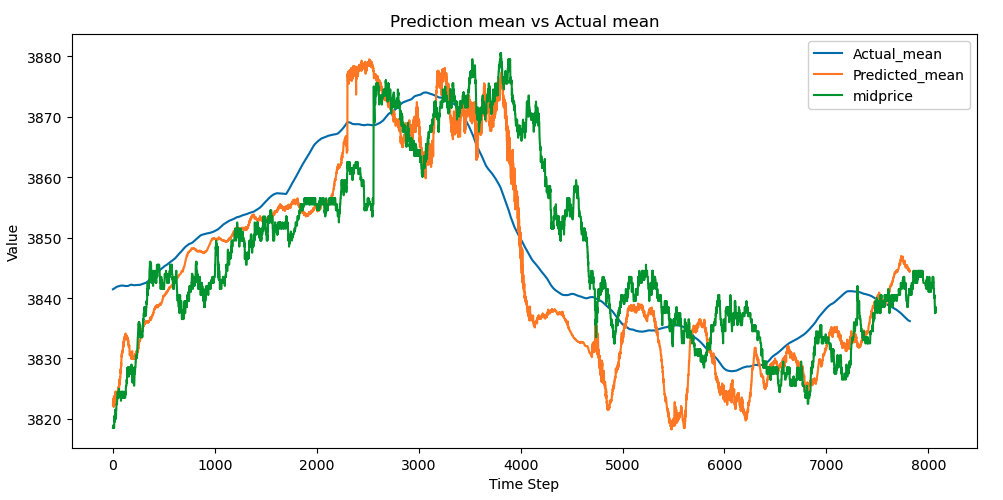

The green line is the exact midprice at present. The blue line is the price mean in next short period.And the orange line is the model's prediction.
**The model makes the reliable predictions before the large midprice jumps with few mistakes.**  The attention mechanism and transformer architecture have indeed demonstrated strong modeling capabilities in short-term prediction for specific commodities. Of course, the factor construction in the feature engineering part is also an important reason why the model can still deliver decent performance without complex modifications.